# Practical 10 Clustering

## 0. Setting up

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os
from matplotlib.colors import ListedColormap

# All of these are potentially useful
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

### 0.1 Scalers for normalisation/ standardisation

In [2]:
rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(-1,1))
pts = PowerTransformer()

### 0.2 Functions for visualisation

In [3]:
def plt_ldn(w, b):
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

########################
# These may no longer be relevant because of changes to geopandas API
'''
def default_cmap(n, outliers=False):
    cmap = mpl.cm.get_cmap('viridis_r', n)
    colors = cmap(np.linspace(0,1,n))
    if outliers:
        gray = np.array([225/256, 225/256, 225/256, 1])
        colors = np.insert(colors, 0, gray, axis=0)
    return ListedColormap(colors)

# mappable = ax.collections[-1] if you add the geopandas
# plot last.
def add_colorbar(mappable, ax, cmap, norm, breaks, outliers=False):
    cb = fig.colorbar(mappable, ax=ax, cmap=cmap, norm=norm,
                    boundaries=breaks,
                    extend=('min' if outliers else 'neither'), 
                    spacing='uniform',
                    orientation='horizontal',
                    fraction=0.05, shrink=0.5, pad=0.05)
    cb.set_label("Cluster Number")
'''

'\ndef default_cmap(n, outliers=False):\n    cmap = mpl.cm.get_cmap(\'viridis_r\', n)\n    colors = cmap(np.linspace(0,1,n))\n    if outliers:\n        gray = np.array([225/256, 225/256, 225/256, 1])\n        colors = np.insert(colors, 0, gray, axis=0)\n    return ListedColormap(colors)\n\n# mappable = ax.collections[-1] if you add the geopandas\n# plot last.\ndef add_colorbar(mappable, ax, cmap, norm, breaks, outliers=False):\n    cb = fig.colorbar(mappable, ax=ax, cmap=cmap, norm=norm,\n                    boundaries=breaks,\n                    extend=(\'min\' if outliers else \'neither\'), \n                    spacing=\'uniform\',\n                    orientation=\'horizontal\',\n                    fraction=0.05, shrink=0.5, pad=0.05)\n    cb.set_label("Cluster Number")\n'

### 1.1 Airbnb listing (csv)

In [4]:
df = pd.read_csv(os.path.join('data', 'raw','2020-08-24-listings.csv.gz'), compression='gzip', 
                 low_memory=False, usecols=['room_type','longitude','latitude','price'])
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 74,188 x 4


In [5]:
df.dropna(axis='rows', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74186 entries, 0 to 74187
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   74186 non-null  float64
 1   longitude  74186 non-null  float64
 2   room_type  74186 non-null  object 
 3   price      74186 non-null  object 
dtypes: float64(2), object(2)
memory usage: 2.8+ MB


In [20]:
# Converting from object to float type, after replacing $ and ,
df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype('float')
df = df[df['price']>0]

# Checking
print(df.describe())
print(df.shape)

       latitude  longitude     price
count 74,179.00  74,179.00 74,179.00
mean      51.51      -0.13    118.79
std        0.19       0.10    257.45
min        2.00      -0.50      7.00
25%       51.48      -0.19     45.00
50%       51.51      -0.13     79.00
75%       51.54      -0.07    129.00
max       51.68       2.00 18,638.00
(74179, 5)


In [23]:
df = df[df['latitude']>40]
df.describe()

,latitude,longitude,price
count,"74,178.00","74,178.00","74,178.00"
mean,51.51,-0.13,118.79
std,0.05,0.10,257.45
min,51.29,-0.50,7.00
25%,51.48,-0.19,45.00
50%,51.51,-0.13,79.00
75%,51.54,-0.07,129.00
max,51.68,0.28,"18,638.00"


In [24]:
# Converting to geopandas and transforming to British National Grid

gdf = gpd.GeoDataFrame(df, 
      geometry=gpd.points_from_xy(df['longitude'], df['latitude'], crs='epsg:4326'))
gdf = gdf.to_crs('epsg:27700')

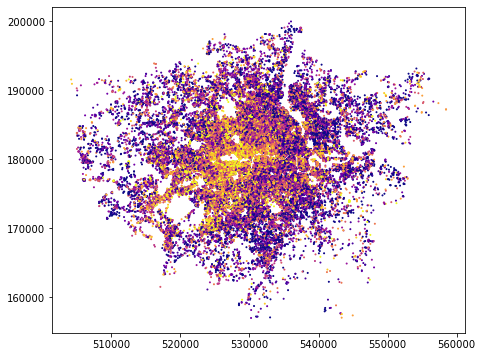

In [25]:
# Checking the info

gdf.plot(column='price', cmap='plasma', scheme='quantiles', k=10, markersize=1, figsize=(8,6));

### 1.2 London MSOA 

In [47]:
msoas = gpd.read_file(os.path.join('data','clean','London_MSOAs.gpkg'), driver='GPKG')
msoas = msoas.drop(columns=['OBJECTID','MSOA11NM','BNG_E','BNG_N','Borough','msoa11hclnm'])

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [49]:
msoas.describe

<bound method NDFrame.describe of       MSOA11CD                                           geometry
0    E02000001  POLYGON ((532135.138 182198.131, 532158.250 18...
1    E02000002  POLYGON ((548881.563 190845.265, 548881.125 19...
2    E02000003  POLYGON ((549102.438 189324.625, 548954.517 18...
3    E02000004  POLYGON ((551550.056 187364.705, 551478.000 18...
4    E02000005  POLYGON ((549099.634 187656.076, 549161.375 18...
..         ...                                                ...
978  E02006927  POLYGON ((541029.881 176265.023, 541101.997 17...
979  E02006928  MULTIPOLYGON (((538300.370 177956.634, 538290....
980  E02006929  POLYGON ((540054.362 179353.134, 540220.354 17...
981  E02006930  POLYGON ((539552.478 178604.042, 539533.000 17...
982  E02006931  POLYGON ((538824.629 177735.438, 538880.250 17...

[983 rows x 2 columns]>

<AxesSubplot:>

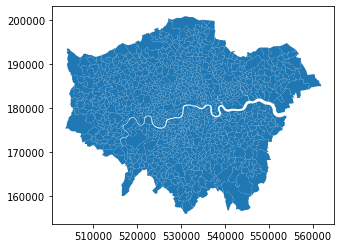

In [40]:
# Checking
msoas.plot()

In [50]:
print(msoas.crs)

epsg:27700


### 1.3 Other area information

In [36]:
# Load Water GeoPackage
water = gpd.read_file(os.path.join('data', 'raw', 'Water.gpkg'), driver = 'GPKG')
print(water.crs)

# Boroughs GeoPackage
boroughs = gpd.read_file(os.path.join('data', 'raw', 'Boroughs.gpkg'), driver = 'GPKG')
print(boroughs.crs)

epsg:27700
epsg:27700


<AxesSubplot:>

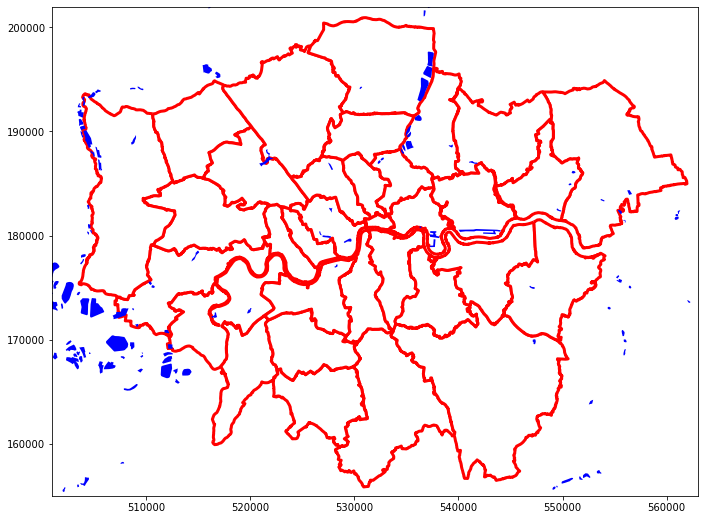

In [38]:
# Checking
fig, ax = plt.subplots(1,1, figsize=(12,9))
ax.set_xlim([501000, 563000])
ax.set_ylim([155000, 202000])

boroughs.plot(ax=ax, edgecolor = "red", facecolor = "white", linewidth = 3)
water.plot(ax=ax, facecolor = "blue")

### 1.4 Reduced dimension data

In [43]:
# Keeping Component 1~10 from PCA

df_reduced = gpd.read_file(os.path.join('data','clean','Reduced_Dimension_Data.gpkg'), driver='GPKG').set_index('MSOA11CD')
df_reduced.drop(columns=['OBJECTID','MSOA11NM','BNG_E','BNG_N','Borough','msoa11hclnm','Subregion',
                   'geometry','Dimension 1','Dimension 2'], inplace=True)
print(f"Reduced Dimensionality Data Frame is {df_reduced.shape[0]:,} x {df_reduced.shape[1]:,}")
df_reduced.head(2)

Reduced Dimensionality Data Frame is 983 x 10


/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10
MSOA11CD,,,,,,,,,,
E02000001,2.72,0.90,-0.10,-1.85,0.16,5.70,4.44,-1.47,-0.68,-0.60
E02000002,-1.13,-0.44,-0.65,-0.69,1.05,0.54,0.91,0.06,0.16,0.98


## 2. Merging data

### 2.1 Merging Airbnb and MSOA data

In [72]:
# master_data containing Airbnb data with MSOAS data (inner joined)
master_data = gpd.sjoin(gdf, msoas, op='within').drop(columns=
    ['latitude','longitude','index_right']
)
master_data.describe

<bound method NDFrame.describe of              room_type  price                       geometry   MSOA11CD
0      Entire home/apt  87.00  POINT (530885.122 175377.940)  E02000633
51        Private room  80.00  POINT (530700.653 175090.560)  E02000633
576       Private room 200.00  POINT (531239.141 175099.960)  E02000633
839       Private room 170.00  POINT (530686.035 175010.067)  E02000633
1882   Entire home/apt 110.00  POINT (531414.745 175083.347)  E02000633
...                ...    ...                            ...        ...
65857  Entire home/apt 168.00  POINT (552572.598 182396.981)  E02000493
64404     Private room  29.00  POINT (551327.419 187222.345)  E02000004
64888     Private room  40.00  POINT (508026.631 187884.474)  E02000498
65414     Private room  40.00  POINT (544932.270 167818.015)  E02000151
73400     Private room  20.00  POINT (553267.785 185381.828)  E02000488

[74140 rows x 4 columns]>

In [75]:
# Number of listing for each MSOA and room_type
master_agg_count = master_data.groupby(['MSOA11CD','room_type'])['price'].agg(Count='count').reset_index() # Reset index -> index now 0, 1, 2...
master_agg_count.head()

,MSOA11CD,room_type,Count
0,E02000001,Entire home/apt,398
1,E02000001,Hotel room,4
2,E02000001,Private room,48
3,E02000001,Shared room,2
4,E02000002,Private room,10


### 2.2 Standardising price data

In [92]:
# Median price for each MSOA
master_agg_medprice = master_data.groupby('MSOA11CD')['price'].agg('median').reset_index()
master_agg_medprice.head()

,MSOA11CD,price
0,E02000001,125.00
1,E02000002,50.00
2,E02000003,40.00
3,E02000004,29.00
4,E02000005,69.00


In [93]:
# Max MSOA median price
master_agg_medprice.max()

MSOA11CD    E02006931
price        1,880.00
dtype: object

It is super skewed -> **power transform**

In [87]:
# Converting the room type x MSOA data to a wide table
master_agg_count = master_agg_count.pivot(index='MSOA11CD', columns=['room_type'], values=['Count']).reset_index()
master_agg_count.head()

MSOA11CD           Count                                    
room_type            Entire home/apt Hotel room Private room Shared room
0          E02000001          398.00       4.00        48.00        2.00
1          E02000002             NaN        NaN        10.00         NaN
2          E02000003            5.00        NaN        19.00         NaN
3          E02000004             NaN        NaN         1.00         NaN
4          E02000005            3.00        NaN         9.00         NaN

In [90]:
# Renaming the columns
master_agg_count.columns = ['MSOA11CD','Entire home/apt','Hotel room','Private room','Shared room']
master_agg_count.head()

,MSOA11CD,Entire home/apt,Hotel room,Private room,Shared room
0,E02000001,398.00,4.00,48.00,2.00
1,E02000002,NaN,NaN,10.00,NaN
2,E02000003,5.00,NaN,19.00,NaN
3,E02000004,NaN,NaN,1.00,NaN
4,E02000005,3.00,NaN,9.00,NaN


In [91]:
# Drop columns with many NaNs
master_agg_count.drop(columns=['Hotel room','Shared room'], inplace=True)
master_agg_count.head()

,MSOA11CD,Entire home/apt,Private room
0,E02000001,398.00,48.00
1,E02000002,NaN,10.00
2,E02000003,5.00,19.00
3,E02000004,NaN,1.00
4,E02000005,3.00,9.00


In [94]:
# Add median price data to the count data -> index: MSOA code
master_agg = pd.merge(master_agg_count, master_agg_medprice, on='MSOA11CD')
master_agg = master_agg.fillna(0).set_index('MSOA11CD')
master_agg.head()

,Entire home/apt,Private room,price
MSOA11CD,,,
E02000001,398.00,48.00,125.00
E02000002,0.00,10.00,50.00
E02000003,5.00,19.00,40.00
E02000004,0.00,1.00,29.00
E02000005,3.00,9.00,69.00


In [95]:
# Fit pts = PowerTransformer()
for c in master_agg.columns.values:
    master_agg[c] = pts.fit_transform(master_agg[c].values.reshape(-1,1)) # Fit_transform -> output is transformed data
master_agg.head(3) # Power Transformed

,Entire home/apt,Private room,price
MSOA11CD,,,
E02000001,2.12,0.81,1.81
E02000002,-1.99,-0.77,-0.21
E02000003,-0.66,-0.16,-0.83


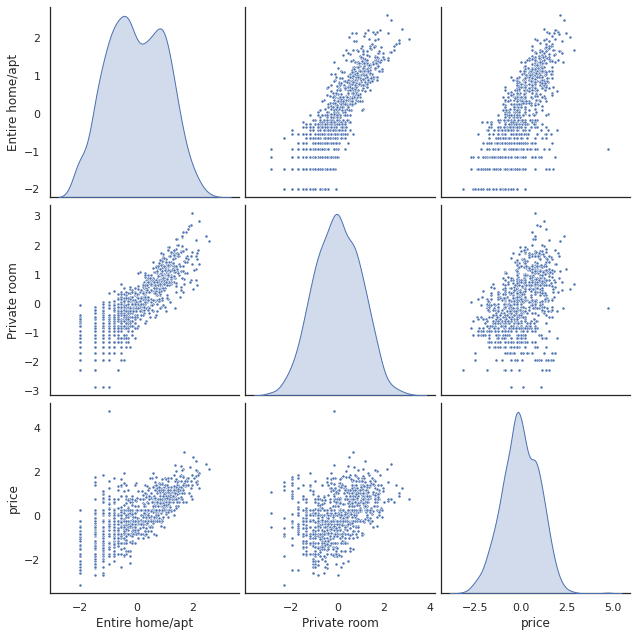

In [97]:
# Visualising the PowerTransform results -> KDEs look a lot more normal
sns.set(style="white")
sns.pairplot(master_agg, markers=".", height=3, diag_kind='kde');

### 2.3 Merging the reduced dimension data (explanatory variables)

In [117]:
# Merging
master_agg_fin = pd.merge(df_reduced, master_agg, left_index=True, right_index=True)  # Joined with index values

# Rescaling with the MinMaxScaler (all variables) - mms = MinMaxScaler(feature_range=(-1,1))
for c in master_agg_fin.columns:
    master_agg_fin[c] = mms.fit_transform(master_agg_fin[c].values.reshape(-1,1))
    
master_agg_fin.head(3)

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,Entire home/apt,Private room,price
MSOA11CD,,,,,,,,,,,,,
E02000001,-0.08,0.12,-0.19,-0.75,-0.16,0.85,0.74,-0.47,-0.24,-0.56,0.80,0.24,0.25
E02000002,-0.88,-0.33,-0.34,-0.52,0.07,-0.12,0.06,-0.21,-0.05,-0.33,-1.00,-0.30,-0.26
E02000003,-0.72,-0.24,0.29,-0.33,-0.12,-0.27,0.08,-0.07,0.01,-0.52,-0.42,-0.09,-0.42


### 2.4 Preparing for analysis output

In [118]:
# Creating the results set with MSOAS geometry added to the analysis data
results   = pd.merge(msoas, master_agg_fin, left_on='MSOA11CD', right_index=True).set_index('MSOA11CD') 
results.head(2)

,geometry,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,Entire home/apt,Private room,price
MSOA11CD,,,,,,,,,,,,,,
E02000001,"POLYGON ((532135.138 182198.131, 532158.250 18...",-0.08,0.12,-0.19,-0.75,-0.16,0.85,0.74,-0.47,-0.24,-0.56,0.80,0.24,0.25
E02000002,"POLYGON ((548881.563 190845.265, 548881.125 19...",-0.88,-0.33,-0.34,-0.52,0.07,-0.12,0.06,-0.21,-0.05,-0.33,-1.00,-0.30,-0.26


In [119]:
# Select components
cols_to_plot = np.random.choice(master_agg_fin.columns.values, 4, replace=False)
print(cols_to_plot)

['Component 9' 'Entire home/apt' 'Component 1' 'Component 7']


## 3. K-means clustering

### 3.1 With pre-defined number of clusters

In [120]:
# Defining parameters
clustering_type   = 'KMeans' # Clustering type
k_cluster = 3                # Number of clusters

kmeans = KMeans(n_clusters=k_cluster, n_init=25, random_state=42).fit(master_agg_fin) # The process
# ninit: Number of time the k-means algorithm will be run with different centroid seeds

print(kmeans.labels_) # The results

[0 1 2 1 1 2 2 2 2 2 2 2 1 1 2 2 2 2 2 1 2 2 1 2 1 2 1 2 1 1 1 2 2 2 1 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2 2 2 1 2 1 2 2 2 2 0 2 0 0 2 2 2 0
 0 2 0 2 2 0 2 0 0 0 0 0 1 1 2 0 2 1 2 2 1 1 1 2 1 2 1 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 0 1 2 2 2 1 1 0 2 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 2 2 1 2 2 2 2 1 1 2 2 2 1 0 2 1 2 2 0 0 2 1 0 0 1 0 0 2 2
 0 2 0 0 2 2 1 2 1 1 2 1 1 1 1 1 1 1 1 2 1 2 2 2 1 2 2 2 1 1 2 2 2 1 2 1 2
 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 0 1 2 2 2 1 1 1 1 1 2 2 1 1 2 0 2 2
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 0 2 2 0
 2 2 0 2 0 0 0 0 1 2 1 1 1 1 2 1 1 2 2 1 2 1 1 1 1 2 2 1 2 2 1 2 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 2 1 1 1 1 1 2 

In [124]:
# Add it to the data frame
results[clustering_type] = pd.Series(kmeans.labels_, index = master_agg_fin.index)
results.head(2)

,geometry,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,Entire home/apt,Private room,price,KMeans
MSOA11CD,,,,,,,,,,,,,,,
E02000001,"POLYGON ((532135.138 182198.131, 532158.250 18...",-0.08,0.12,-0.19,-0.75,-0.16,0.85,0.74,-0.47,-0.24,-0.56,0.80,0.24,0.25,0
E02000002,"POLYGON ((548881.563 190845.265, 548881.125 19...",-0.88,-0.33,-0.34,-0.52,0.07,-0.12,0.06,-0.21,-0.05,-0.33,-1.00,-0.30,-0.26,1


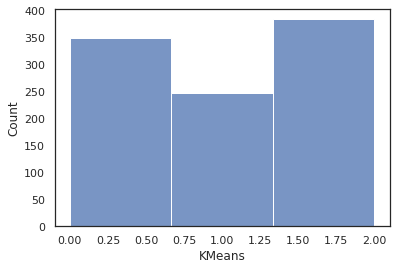

In [127]:
# How are the clusters distributed?
ax = sns.histplot(data=results, x=clustering_type, bins=k_cluster);

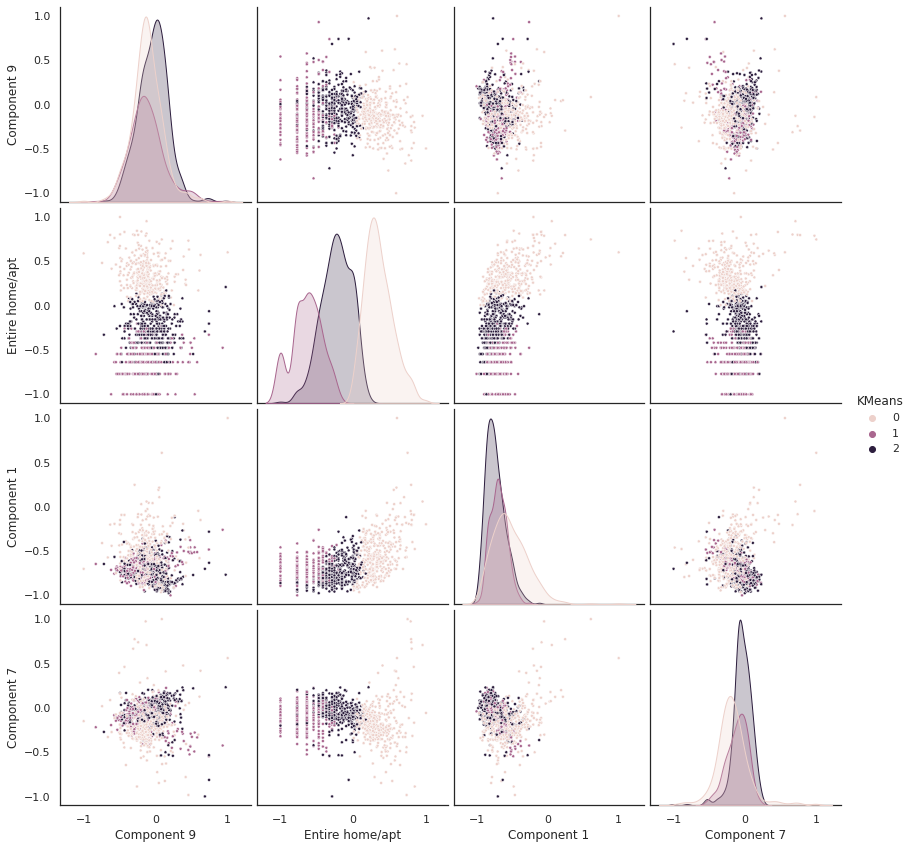

In [129]:
# Pairpolot with randomly chosen columns
sns.set(style="white")
sns.pairplot(results, 
             vars=cols_to_plot, 
             hue=clustering_type, markers=".", height=3, diag_kind='kde');

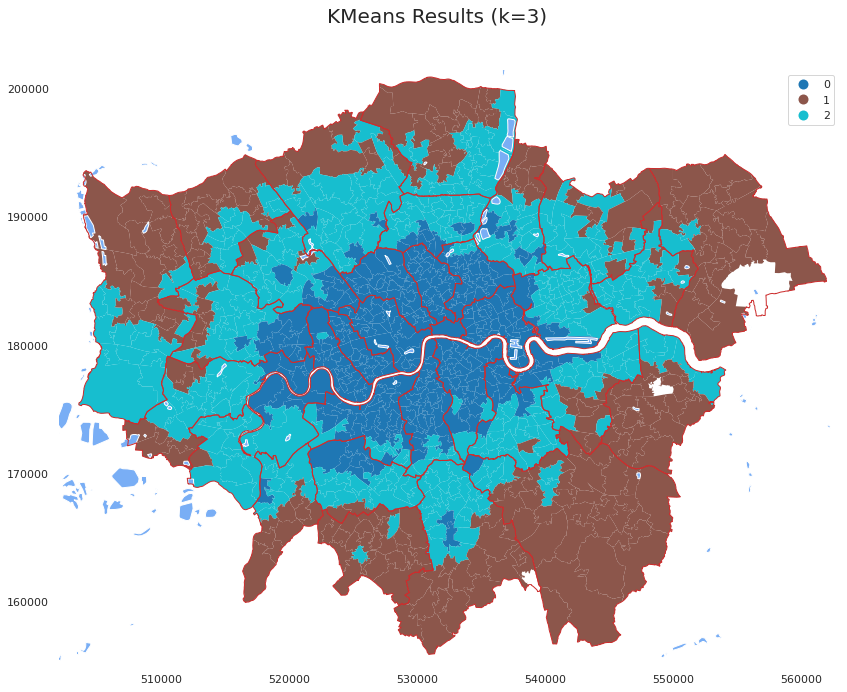

In [134]:
# Outputing the clustering results on the London map (function plt_ldn defined in preamble)
fig, ax = plt_ldn(water, boroughs)
fig.suptitle(f"{clustering_type} Results (k={k_cluster})", fontsize=20, y=0.92)
results.plot(column=clustering_type, ax=ax, linewidth=0, zorder=0, categorical=True, legend=True);

### 3.2 Silhouette scores - finding the right number of clusters

Multiple ways to choose the number of clusters
- Elbow method: For each value of K, we are calculating WCSS ( Within-Cluster Sum of Square ). WCSS is the sum of squared distance between each point and the centroid in a cluster. The principle of this approach is that you look for the point where there is declining benefit from adding more clusters.
- Silhouette plot: based on Partitioning Around the Medoid (PAM).　The PAM algorithm searches for k representative objects in a data set (k medoids) and then assigns each object to the closest medoid in order to create clusters.

To evaluate this in a systematic way, we want to do multiple k-means clusterings for multiple values of k and then we can look at which gives the best results...

.......................................
Largest silhouette score was 0.2811 for k=2


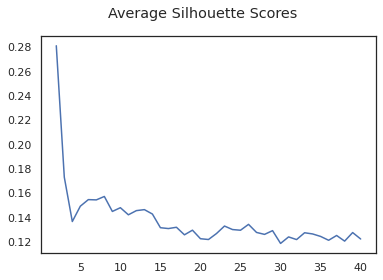

In [136]:
# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import silhouette_samples, silhouette_score

x = [] # Average silhouette score over variables
y = [] # Number of clusters

for k in range(2,41):
    
    # Do the clustering using the main columns
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42).fit(master_agg_fin)
    
    # Calculate the silhouette score (X, labels)
    silhouette_avg = silhouette_score(master_agg_fin, kmeans.labels_)
    
    y.append(k)
    x.append(silhouette_avg)
    
    print('.', end='')

print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}") 
# Largest silhouette score = large inter-cluster, small intra-cluster distance
# -1 (poorly clustered) <= silouhette score <= 1 (well clustered)

plt.plot(y, x)
plt.gcf().suptitle("Average Silhouette Scores");

In this case, the ideal cluster number is k = 2

### 3.3 Clustering with chosen cluster number

Here, choose a cluster number of k = 7 (next best clustering to k = 2)

In [137]:
k_pref=7
    
#############
# Do the clustering using the main columns
kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(master_agg_fin)

# Convert to a series
results[clustering_type] = pd.Series(kmeans.labels_, index=master_agg_fin.index, name=clustering_type)
    
# Calculate the overall silhouette score for k = 7
silhouette_avg = silhouette_score(master_agg_fin, kmeans.labels_)

# Calculate the silhouette values
sample_silhouette_values = silhouette_samples(master_agg_fin, kmeans.labels_)

In [143]:
len(sample_silhouette_values) # Silhouette values calculated for each entry (rows = MSOA)

980

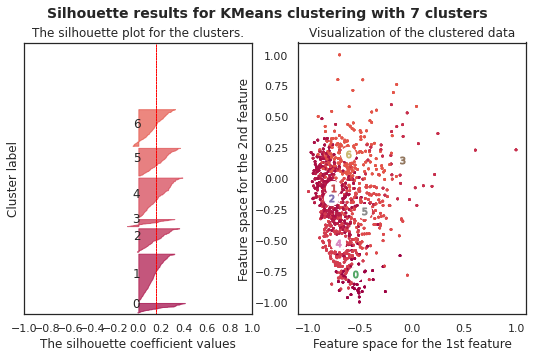

In [145]:
# Visualising the Silhouette score sample results

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(9, 5)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1
ax1.set_xlim([-1.0, 1.0]) # Changed from -0.1, 1
    
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, master_agg_fin.shape[0] + (k + 1) * 10])
    
y_lower = 10
    
# For each of the clusters...
for i in range(k_pref):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[kmeans.labels_ == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    # Set the color ramp
    color = plt.cm.Spectral(i/k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=0.5)

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-1.0, 1.1, 0.2)) # Was: [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]

    # 2nd Plot showing the actual clusters formed --
    # we can only do this for the first two dimensions
    # so we may not see fully what is causing the 
    # resulting assignment
    colors = plt.cm.Spectral(kmeans.labels_.astype(float) / k)
    ax2.scatter(master_agg_fin[master_agg_fin.columns[0]], master_agg_fin[master_agg_fin.columns[1]], 
                marker='.', s=30, lw=0, alpha=0.7, c=colors)

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("Visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette results for KMeans clustering "
                "with %d clusters" % k_pref),
                fontsize=14, fontweight='bold')

plt.show()

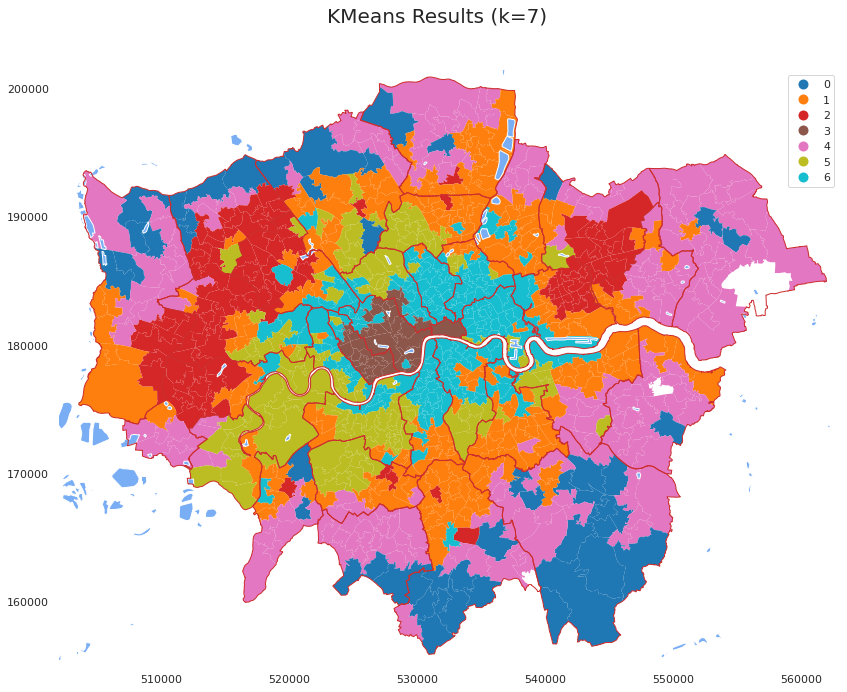

In [147]:
# Outputing the clustering results on the London map (function plt_ldn defined in preamble)
fig, ax = plt_ldn(water, boroughs)
fig.suptitle(f"{clustering_type} Results (k={k_pref})", fontsize=20, y=0.92)
results.plot(column=clustering_type, ax=ax, linewidth=0, zorder=0, categorical=True, legend=True);

### 3.4 Checking the variation of each explanatory variables over clusters

To get a sense of how these clusters differ we can try to extract 'representative' centroids (mid-points of the multi-dimensional cloud that constitutes a cluster). In the case of k-means this will work quite will since the clusters are explicitly built around mean centroids.

Processing cluster 0
Processing cluster 1
Processing cluster 2
Processing cluster 3
Processing cluster 4
Processing cluster 5
Processing cluster 6


/tmp/ipykernel_1318/2229796147.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  centroids = centroids.append(c.mean(), ignore_index=True)


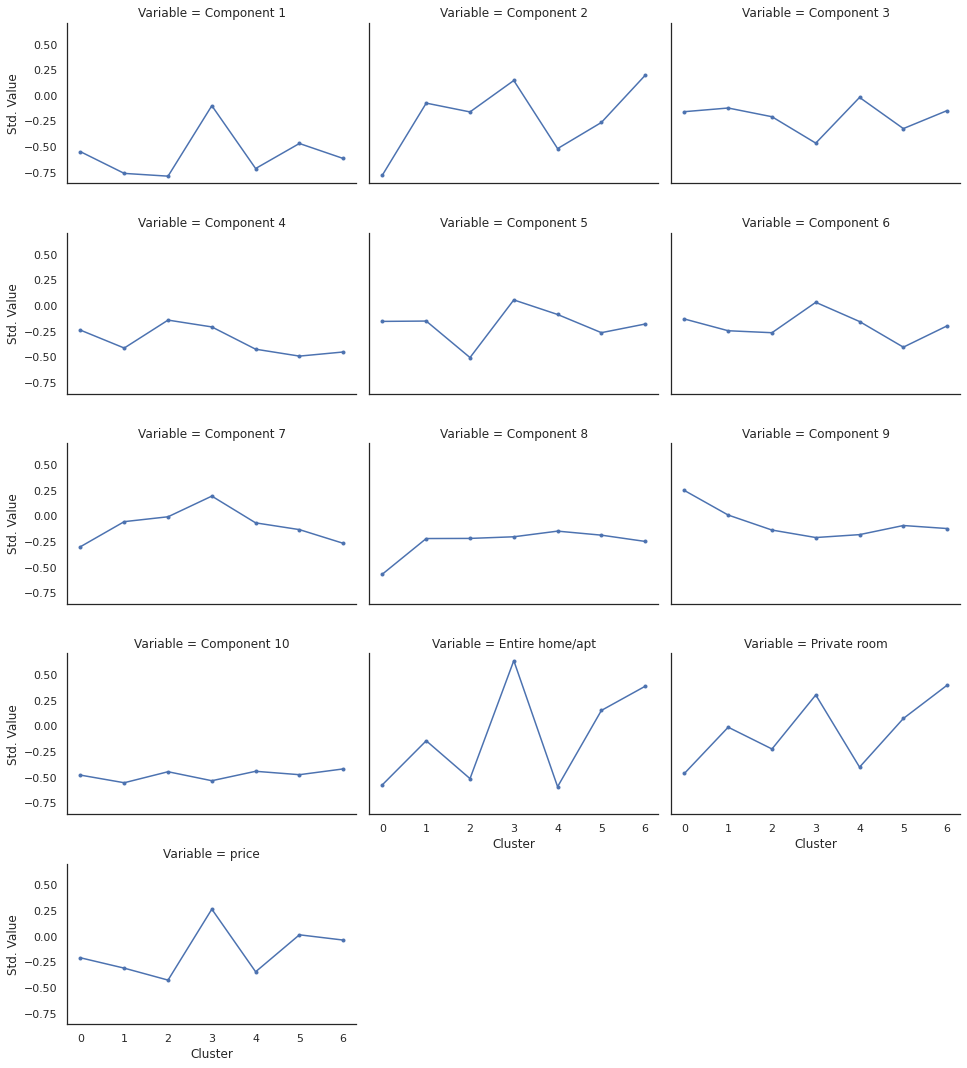

In [148]:
centroids = None
for k in sorted(results[clustering_type].unique()):
    print(f"Processing cluster {k}")

    c = results[results[clustering_type]==k]
    if centroids is None:
        centroids = pd.DataFrame(columns=c.columns.values)
    centroids = centroids.append(c.mean(), ignore_index=True)
    
odf = pd.DataFrame(columns=['Variable','Cluster','Std. Value'])
for i in range(0,len(centroids.index)):
    row = centroids.iloc[i,:]
    c_index = list(centroids.columns.values).index(clustering_type)
    for c in range(0,c_index):
        d = {'Variable':centroids.columns[c], 'Cluster':row[c_index], 'Std. Value':row[c]}
        odf = odf.append(d, ignore_index=True)
        
odf = odf[~odf.Variable.isin(['Borough','msoa11hclnm','Subregion','geometry'])]
g = sns.FacetGrid(odf, col="Variable", col_wrap=3, height=3, aspect=1.5, margin_titles=True, sharey=True)
g = g.map(plt.plot, "Cluster", "Std. Value", marker=".")

## 4. DBSCAN

Works well only for low dimension data

### 4.0 Narrowing down explanatory variables for simplicity

In [187]:
# Picking 2 components to conduct
master_agg_fin_2 = master_agg_fin.loc[:,['Component 1','Component 2']]
master_agg_fin_2.head()

,Component 1,Component 2
MSOA11CD,,
E02000001,-0.08,0.12
E02000002,-0.88,-0.33
E02000003,-0.72,-0.24
E02000004,-0.83,-0.58
E02000005,-0.84,-0.30


### 4.1 Choosing the epsilon value using nearest neighbour plot

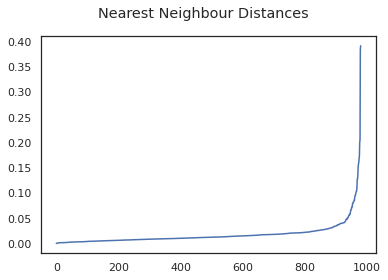

In [188]:
nbrs = NearestNeighbors(n_neighbors=4).fit(master_agg_fin_2)
distances, indices = nbrs.kneighbors(master_agg_fin_2)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.gcf().suptitle("Nearest Neighbour Distances");

In [189]:
c_nm = 'DBSCAN'

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.4f}'.format(x))

el  = []

max_clusters  = 10
cluster_count = 1

iters = 0

for e in np.arange(0.025, 0.25, 0.005):
    
    if iters % 25==0: print(f"{iters} epsilons explored.") 
    
    # Run the clustering
    dbs = DBSCAN(eps=e, min_samples= master_agg_fin_2.shape[1]+1).fit(master_agg_fin_2)
    
    # See how we did
    s = pd.Series(dbs.labels_, index=master_agg_fin_2.index, name=c_nm)
    
    row = [e]
    data = s.value_counts()
    
    for c in range(-1, max_clusters+1):
        try:
            if np.isnan(data[c]):
                row.append(None)
            else: 
                row.append(data[c])
        except KeyError:
            row.append(None)
    
    el.append(row)
    iters+=1

edf = pd.DataFrame(el, columns=['Epsilon']+["Cluster " + str(x) for x in list(range(-1,max_clusters+1))])

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

print("Done.")

0 epsilons explored.
25 epsilons explored.
Done.


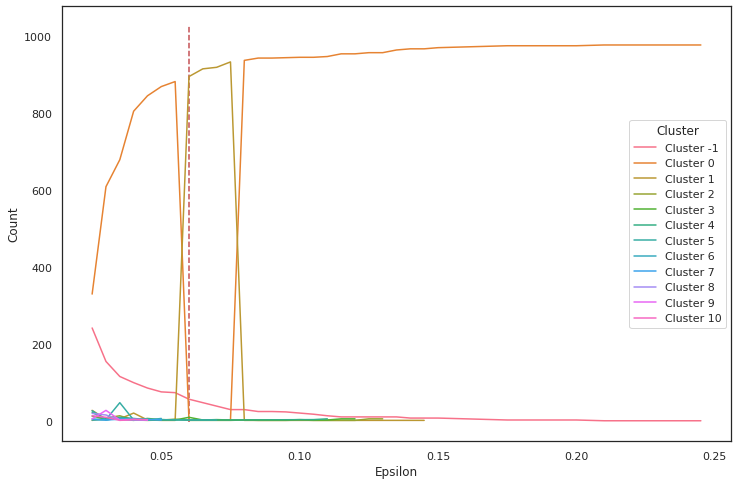

In [190]:
odf = pd.DataFrame(columns=['Epsilon','Cluster','Count'])

for i in range(0,len(edf.index)):
    row = edf.iloc[i,:]
    for c in range(1,len(edf.columns.values)):
        if row[c] != None and not np.isnan(row[c]):
            d = {'Epsilon':row[0], 'Cluster':f"Cluster {c-2}", 'Count':row[c]}
            odf = odf.append(d, ignore_index=True)

odf['Count'] = odf.Count.astype(float)

fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=odf, x='Epsilon', y='Count', hue='Cluster');
ax.vlines(0.06, 0, ax.get_ylim()[1], linestyle='dashed', color='r');

### 4.2 Conducting DBSCAN

In [196]:
e = 0.06
dbs = DBSCAN(eps=e, min_samples=master_agg_fin.shape[1]+1).fit(master_agg_fin.values)
s = pd.Series(dbs.labels_, index=master_agg_fin.index, name='DBSCAN')
results['DBSCAN'] = s
print(s.value_counts())

-1    980
Name: DBSCAN, dtype: int64


## 5. OPTICS

In [150]:
from sklearn.cluster import OPTICS

## 6. Self-organising maps (SOM)

In [149]:
from sompy.sompy import SOMFactory

# SOM is a bit like PCA or t-SNE